In [92]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
sns.set_style('whitegrid')

## Load and default preprocessing

In [27]:
# load data
with open('../witt_preprocessing/pickles/dangjin_merged.pkl','rb') as f:
    dangjin_data = pickle.load(f)
with open('../witt_preprocessing/pickles/ulsan_merged.pkl','rb') as f:
    ulsan_data = pickle.load(f)


# preprocess data for modeling

# time as index
dangjin_data.set_index('time', inplace=True)
ulsan_data.set_index('time', inplace=True)

# dangjin - sum target values
dangjin_data['dangjin_sum'] = dangjin_data['dangjin'] + dangjin_data['dangjin_floating'] + dangjin_data['dangjin_warehouse']
dangjin_data.drop(columns=['dangjin','dangjin_floating','dangjin_warehouse'], inplace=True)

# delete rows where target == 0
dangjin_data_full = dangjin_data.copy()
ulsan_data_full = ulsan_data.copy()

dangjin_data = dangjin_data.loc[dangjin_data['dangjin_sum'] != 0]
ulsan_data = ulsan_data.loc[ulsan_data['ulsan'] != 0]

## Functions

In [84]:
def validate(model, data, x_cols, y_cols, test_size=0.2):
    '''
    model: sklearn model
    data: pd.DataFrame
    x_cols: list
    y_col: list
    test_size = float or int
    '''

    # input-target split
    x = data.loc[:,x_cols]
    y = data.loc[:,y_cols]

    # train-test split
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=test_size, shuffle=False)

    # fit and predict
    model.fit(train_x, train_y)
    predict = model.predict(test_x)

    return predict, test_y

In [24]:
def evaluate(predict, y):
    return abs(predict - y.iloc[:,0]).mean(axis=0)

## X and Y

In [5]:
x_cols_obs = ['Temperature_obs', 'Humidity_obs','Cloud_obs','Day_cos','Day_sin','Year_cos','Year_sin']
x_cols_fcst = ['Temperature_fcst','Humidity_fcst','Cloud_fcst','Day_cos','Day_sin','Year_cos','Year_sin']

y_dangjin_cols = ['dangjin_sum']
y_ulsan_cols = ['ulsan']

## Experiment 1: Ensemble different timesteps (from 0,3,6,9)
-> 단순한 shift로는 성능 저하 심함

In [7]:
timesteps = [0,1,2,3]

def ensemble_timestep(data, x_cols, y_cols):
    predicts = []

    # test set size 미리 정하기. 비율로 split할 경우 ts별 size 불일치.
    test_size = int(data.shape[0] * 0.2)

    for ts in timesteps:
        print('='*50, ts, '='*50)

        # shift data
        data_shifted = data.copy()
        data_shifted[x_cols] = data_shifted[x_cols].shift(ts)
        data_shifted.dropna(inplace=True)

        # validate
        model = RandomForestRegressor(criterion='mae', verbose=0, n_jobs=-1, random_state=27, n_estimators=100, min_samples_leaf=10)
        predict, test_y = validate(model, data_shifted, x_cols, y_cols, test_size=test_size)
        predicts.append(predict)

    return predicts, test_y  # test_y is always same

In [ ]:
ensemble_predict, test_y = ensemble_timestep(dangjin_data, x_cols_fcst, y_dangjin_cols)

In [ ]:
ensemble_predict_mean = np.stack(ensemble_predict, axis=0).mean(axis=0)

In [ ]:
for i in range(4):
    prnt(evaluate((ensemble_predict[i], test_y))

evaluate(ensemble_predict_mean, test_y)

## Experiment 2: Hp tuning 
> min_samples_leaf alone
- 4- 6- 5- 7- 3

> max_depth alone
- np.arange(20,45,step=5)
- min = 3866xx
- => better to use other hps

> 

In [ ]:
# Hp tuning
msl_list = np.arange(3,8,step=1) # hp(min_samples_leaf) list
ITER = 1

# dictionary to store errors
error_by_msl = {x:[] for x in msl_list}

# loop over msl
for msl in msl_list:
        # iter
    for i in range(ITER):
        print('min_samples_leaf:',msl,'iter:',i) 
        model = RandomForestRegressor(criterion='mae', verbose=0, n_jobs=-1, n_estimators=100, min_samples_leaf=msl)

        predict, test_y = validate(model, dangjin_data, x_cols_fcst, y_dangjin_cols)

        error_by_msl[msl].append(evaluate(predict, test_y))

error_by_msl = pd.DataFrame(error_by_msl)
error_by_msl.loc['mean',:] = error_by_msl.mean(axis=0)

In [ ]:
error_by_msl

In [ ]:
# Hp tuning
depth_list = np.arange(20,50,step=5)
ITER = 1

# dictionary to store errors
error_by_depth = {x:[] for x in depth_list}

# loop over depth
for depth in depth_list:
        # iter
    for i in range(ITER):
        print('min_samples_leaf:',depth,'iter:',i) 
        model = RandomForestRegressor(criterion='mae', verbose=0, n_jobs=-1, n_estimators=100, max_depth=depth)

        predict, test_y = validate(model, dangjin_data, x_cols_fcst, y_dangjin_cols)

        error_by_depth[depth].append(evaluate(predict, test_y))

error_by_depth = pd.DataFrame(error_by_depth)
error_by_depth.loc['mean',:] = error_by_depth.mean(axis=0)

In [ ]:
error_by_depth

## Plot

In [11]:
# window (for plot)
def window(predict, target, window_start=0, window_size=None):

    if window_size: # if window_size given, slice data
        if window_start + window_size > predict.size + 1: # if window exceeds the data
            predict_sample = predict[window_start:]
            target_sample = target[window_start:]   
        else:
            predict_sample = predict[window_start : window_start + window_size]
            target_sample = target[window_start : window_start + window_size]

    else: # if window_size not given, use the whole data
        predict_sample = predict
        target_sample = target

    return predict_sample, target_sample    

In [85]:
# single rf model
model = RandomForestRegressor(criterion='mae', verbose=0, n_jobs=-1, n_estimators=100, min_samples_leaf=4)

predict, test_y = validate(model, dangjin_data, x_cols_fcst, y_dangjin_cols)

<ipython-input-84-0f0abbab3e48>:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


In [55]:
evaluate(predict, test_y)

145.38152173066302

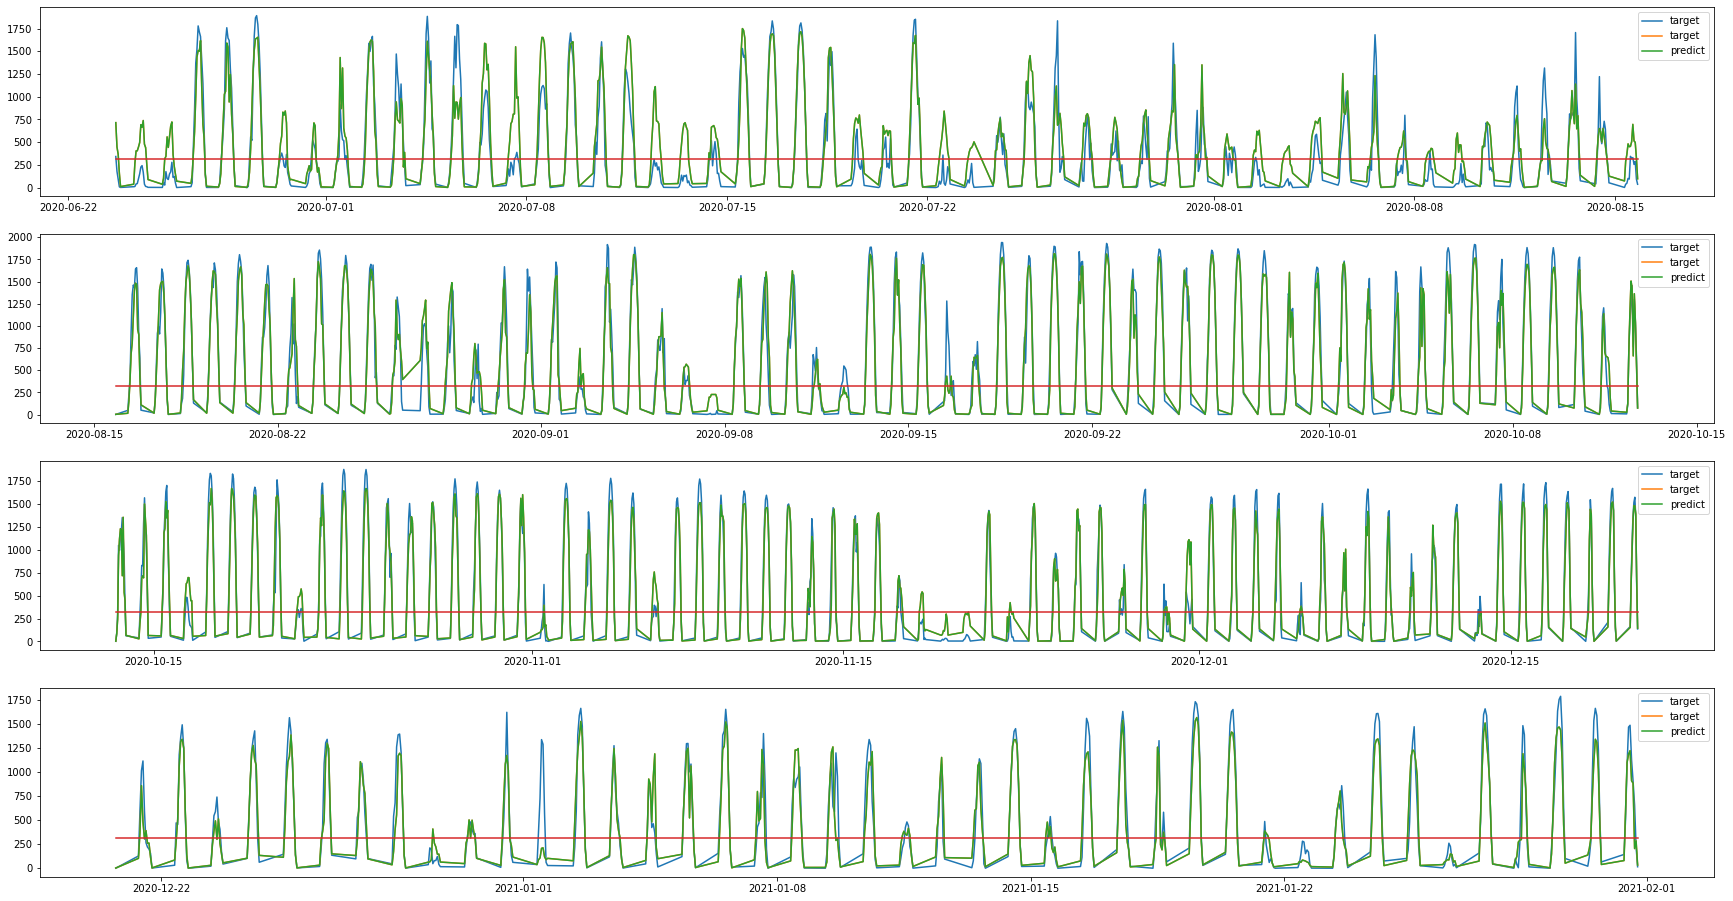

In [52]:
N = 4
fig, ax = plt.subplots(N,1, figsize=(30,4*N))

for n in range(N):
    predict_sample, target_sample = window(predict, test_y, window_start=24*30*n, window_size=24*30)

    ax[n].plot(target_sample, label='target')
    ax[n].plot(pd.Series(predict_sample, index=target_sample.index), label='predict')
    ax[n].plot(target_sample.index, [320 for _ in target_sample.index]) # 320 is the 10% of 총 발전용량
    ax[n].legend()
plt.show()

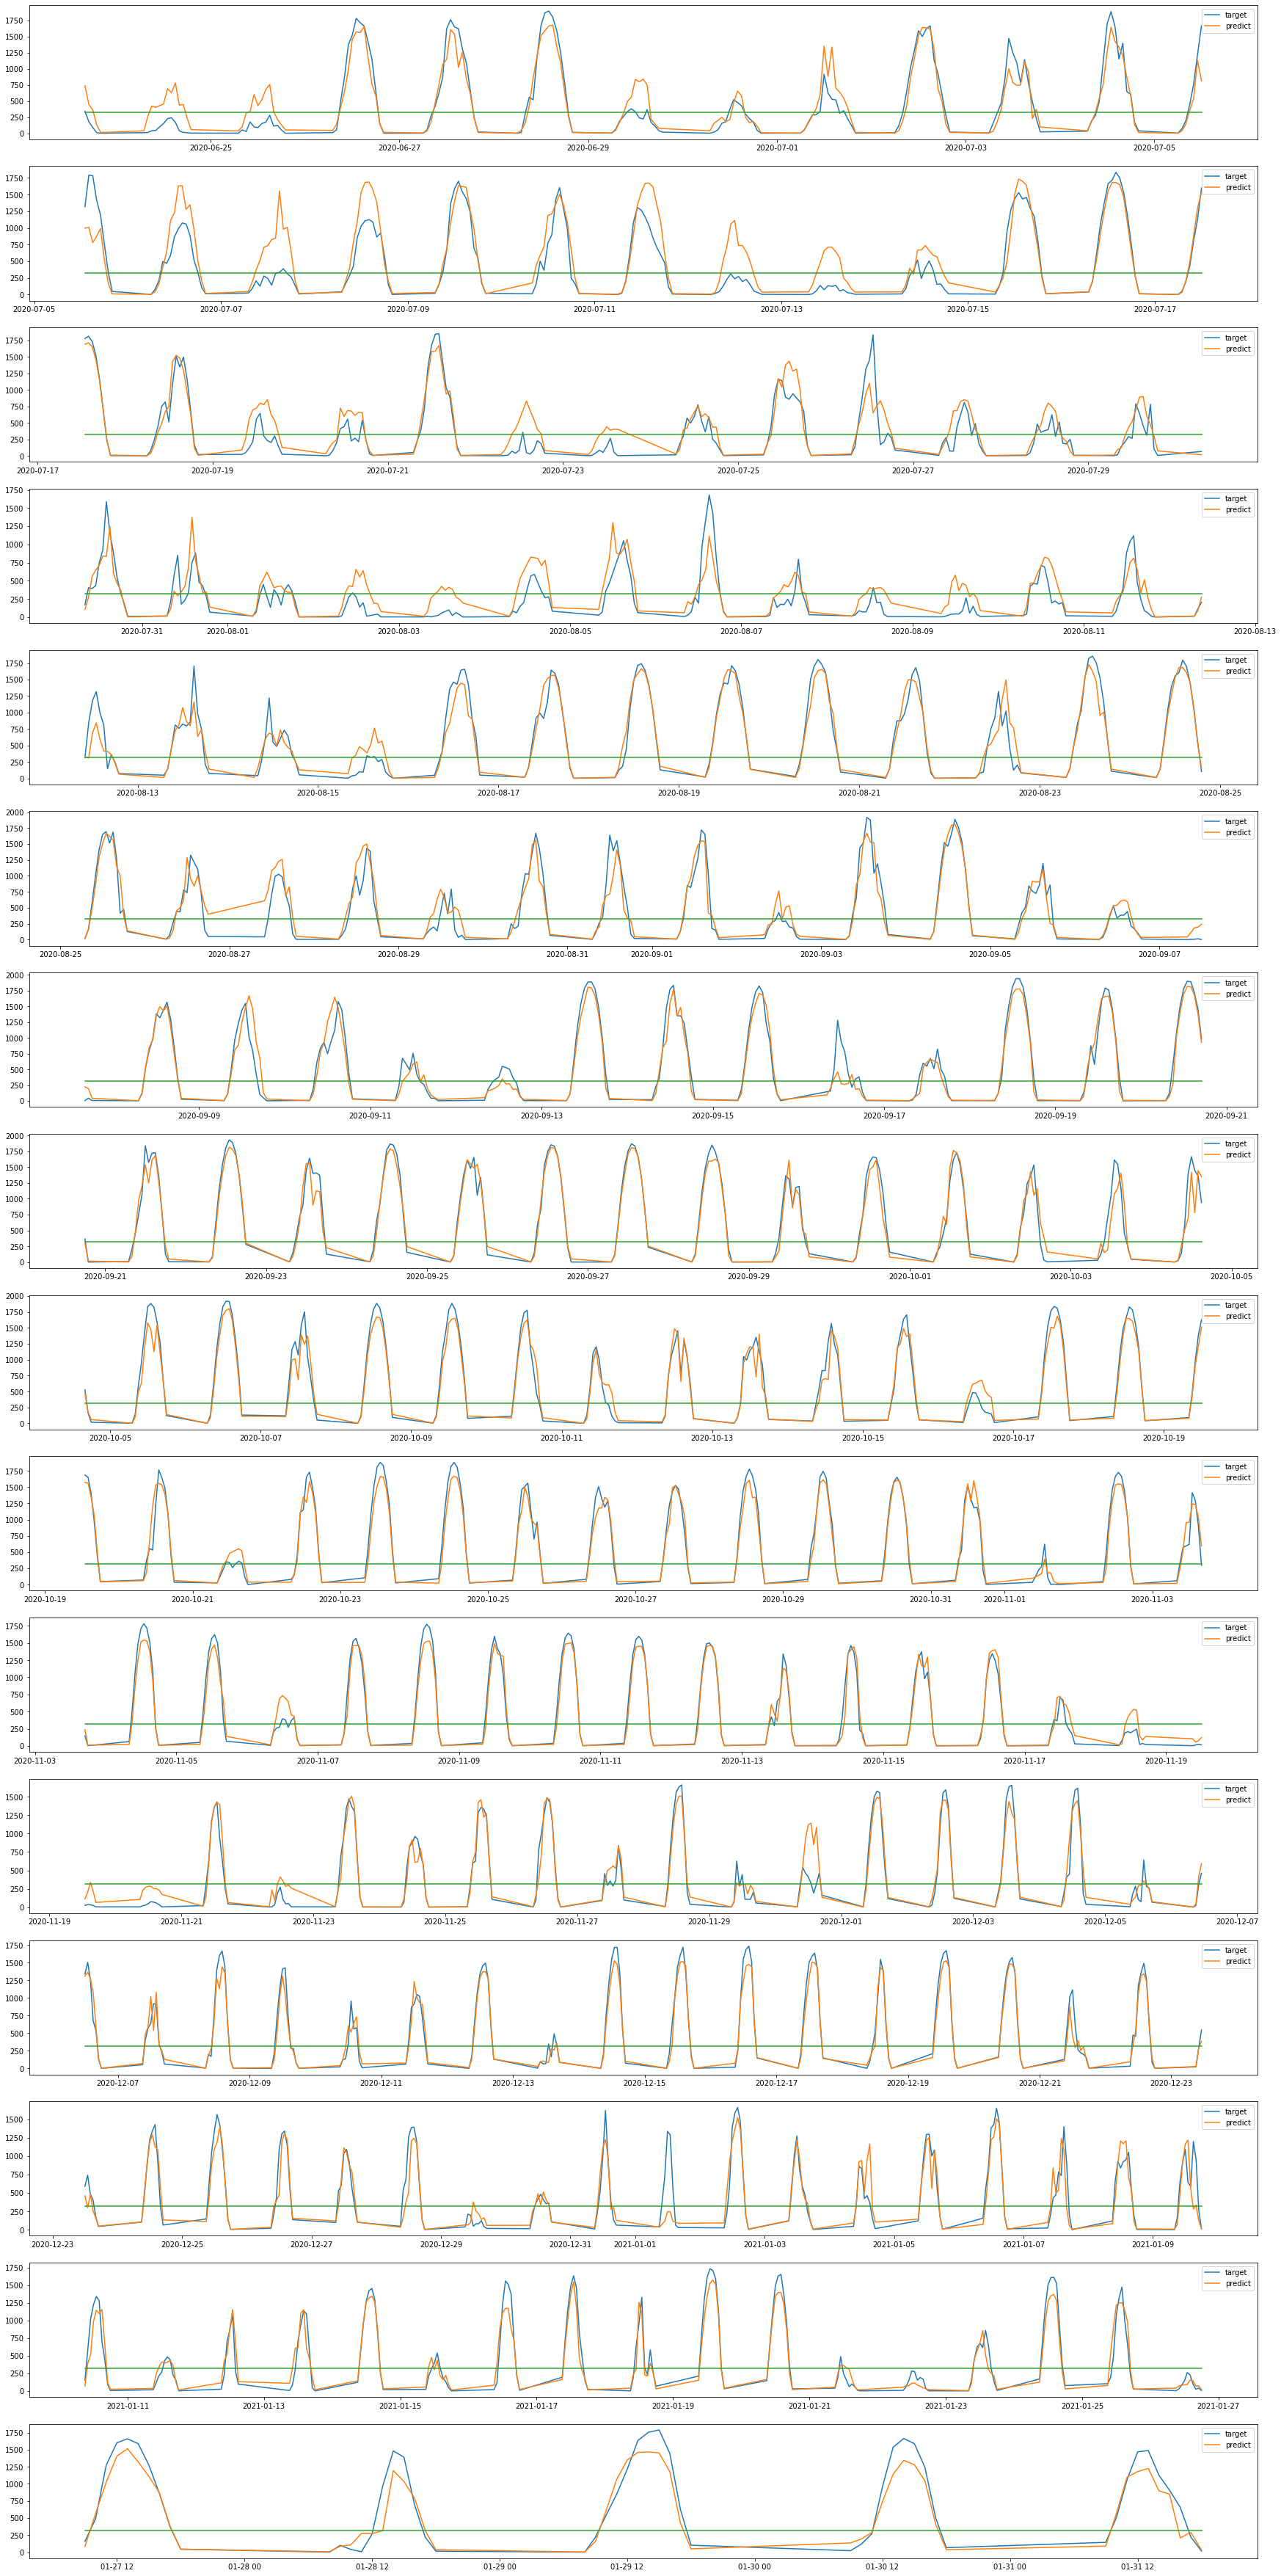

In [56]:
N = 16
fig, ax = plt.subplots(N,1, figsize=(30,4*N))

for n in range(N):
    predict_sample, target_sample = window(predict, test_y, window_start=24*7*n, window_size=24*7)

    ax[n].plot(target_sample, label='target')
    ax[n].plot(pd.Series(predict_sample, index=target_sample.index), label='predict')
    ax[n].plot(target_sample.index, [320 for _ in target_sample.index])
    ax[n].legend()
plt.show()

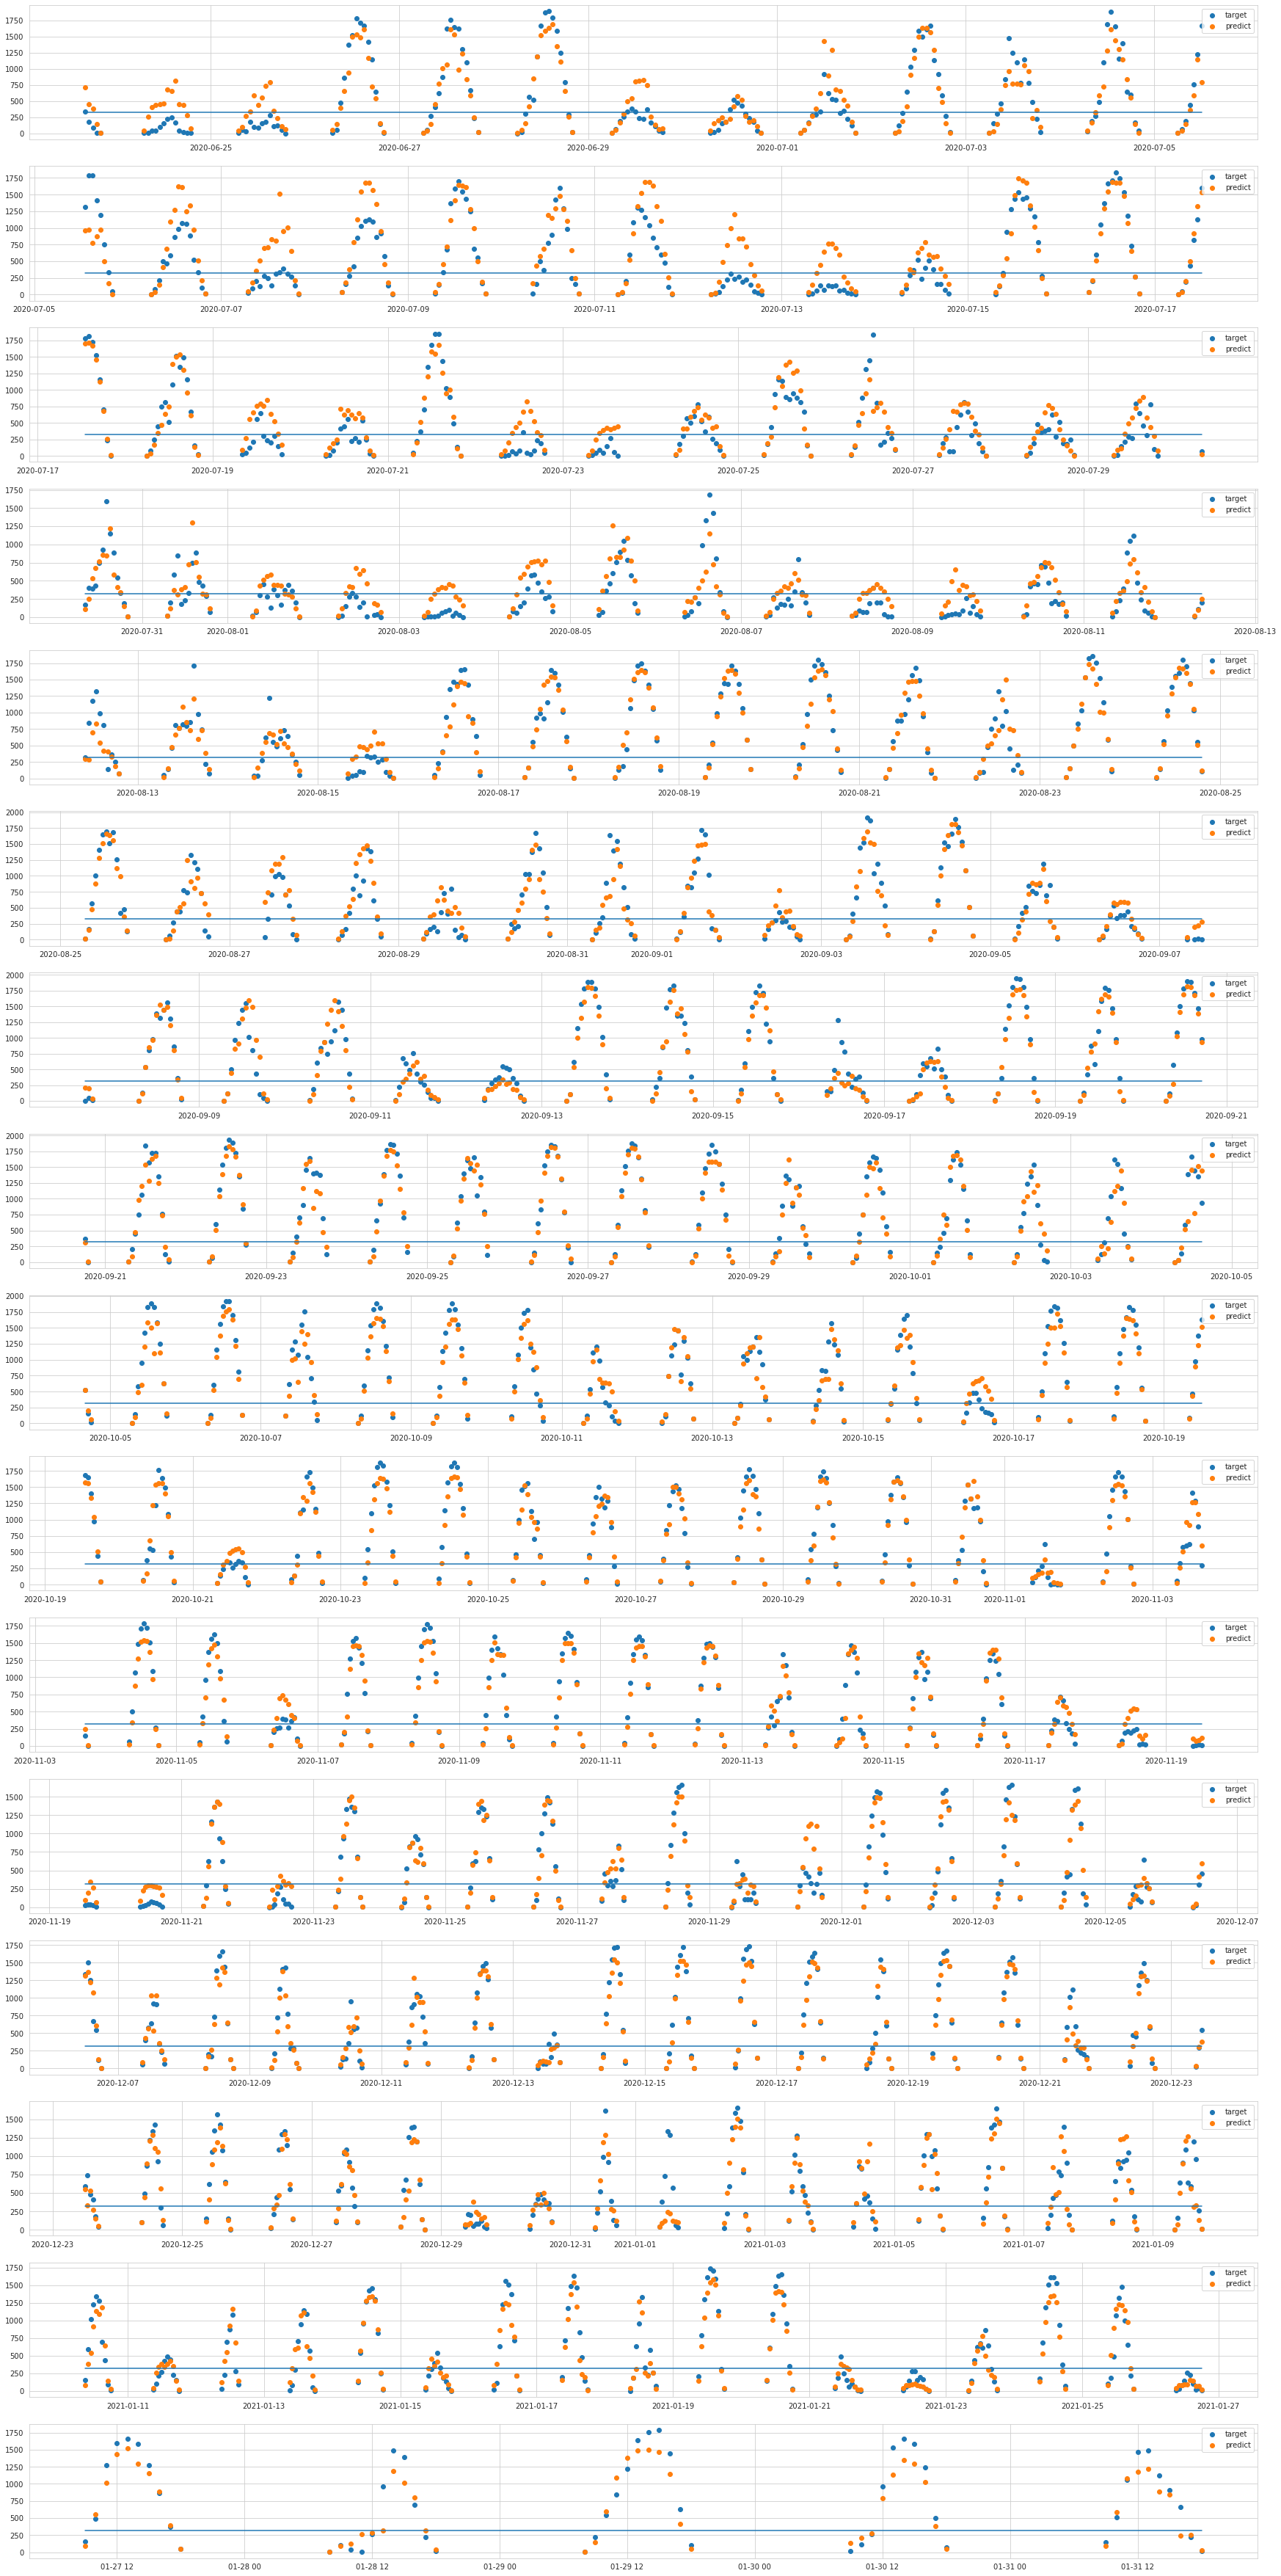

In [91]:
N = 16
fig, ax = plt.subplots(N,1, figsize=(30,4*N))

for n in range(N):
    predict_sample, target_sample = window(predict, test_y, window_start=24*7*n, window_size=24*7)

    ax[n].scatter(target_sample.index, target_sample, label='target')
    ax[n].scatter(target_sample.index, pd.Series(predict_sample, index=target_sample.index), label='predict')
    ax[n].plot(target_sample.index, [320 for _ in target_sample.index])
    ax[n].legend()
    #ax[n].grid(which='both', axis='x')
plt.show()

# problem?: does not predict on night time

## Error by time

In [104]:
test_y['predict'] = predict
test_y['error'] = abs(test_y['dangjin_sum'] - test_y['predict'])
test_y['percentage_error'] = test_y['error'] / test_y['dangjin_sum']
test_y['hour'] = test_y.index.hour 

In [105]:
test_y.groupby('hour').mean() # 12시와 15시

dangjin_sum      predict       error  percentage_error
hour                                                        
6        3.153846     4.263462    3.109615          1.917060
7       18.299458    16.717917   13.533563          2.460884
8       87.251364    84.417005   39.728583          2.140205
9      266.704314   267.021171   90.707194          2.300715
10     563.862245   550.906016  147.834447          0.928460
11     838.066277   821.906711  200.847417          0.961135
12    1054.408366  1064.745973  215.569683          1.842537
13    1165.492899  1123.302557  220.922560          0.453657
14    1124.328972  1121.362376  217.661619          0.566893
15     995.563235  1051.415271  205.571583          1.766364
16     708.420206   733.392432  170.264047          1.200676
17     374.678885   408.074027  110.380349          1.494329
18     165.140434   185.418519   67.896716          2.562541
19      78.641583   107.123678   46.004279          4.894373
20       9.593750     8.917969    6.631094          1.588506

## Peak Prediction

In [44]:
# load peak prediction
with open('peak_prediction.pkl', 'rb') as f:
    peak_predict = pickle.load(f)

In [45]:
# original prediction
test_y['predict'] = predict
test_y_peak = test_y.loc[peak_predict.index]

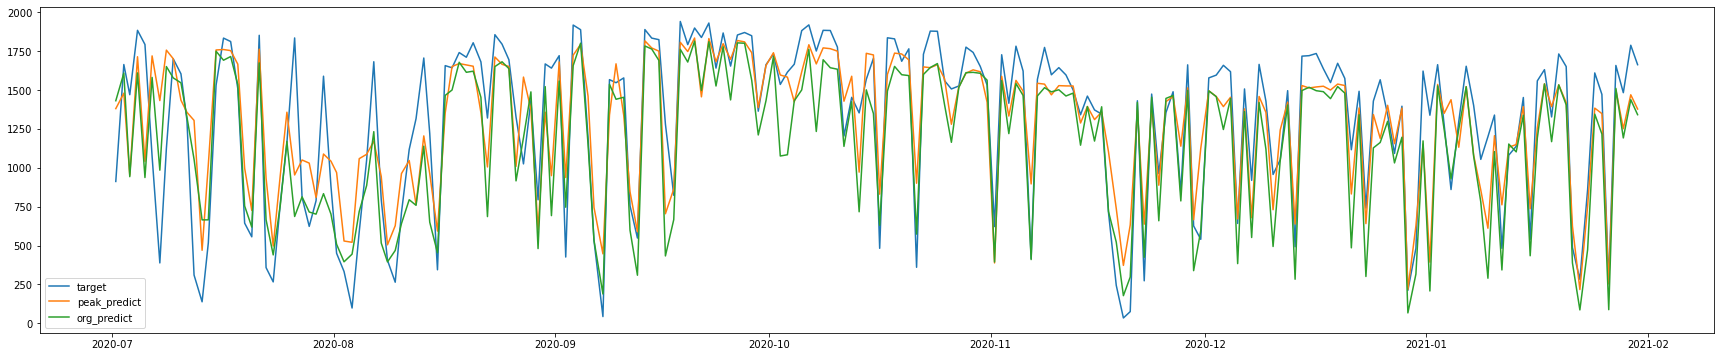

In [46]:
# plot
plt.figure(figsize=(30,6))
plt.plot(peak_predict['dangjin_sum'], label='target')
plt.plot(peak_predict['predict'], label='peak_predict')
plt.plot(test_y_peak['predict'], label='org_predict')
plt.legend()

In [47]:
# compare MAE
print('peak_predict:',abs(peak_predict['dangjin_sum'] - peak_predict['predict']).mean())
print('org_predict:',abs(peak_predict['dangjin_sum'] - test_y_peak['predict']).mean())

peak_predict: 209.73181219105203
org_predict: 219.85909450745655


## Hall of Fame
- 374043: x_cols_fcst; min_sample_leaf=4